In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [126]:
import tensorflow as tf
import cv2

# Creating a model
from tensorflow.keras.models import Sequential 

# Elements of neural network
from tensorflow.keras.layers import Conv2D, GlobalAvgPool2D, Dense, MaxPool2D, Dropout

# Loss/Error function for binary classification (my face, not my face)
from tensorflow.keras.losses import BinaryCrossentropy

In [127]:
# CREATE A MODEL
# Amount of filters in the first layer, e.g. 16
f = 16

m = Sequential([
    #### FEATURE EXTRACTION
    Conv2D(f, (5,5), strides=2, padding='same', input_shape=(128,128,3), activation='relu'),
    Conv2D(f*2, (3,3), strides=2, padding='same', activation='relu'),
    Conv2D(f*4, (3,3), strides=1, padding='same', activation='relu'),
    Conv2D(f*4, (3,3), strides=1, padding='same', activation='relu'),
    MaxPool2D(),
    Conv2D(f*4, (3,3), strides=1, padding='same', activation='relu'),
    Conv2D(f*4, (3,3), strides=1, padding='same', activation='relu'),
    MaxPool2D(),
    GlobalAvgPool2D(),
    # FULLY CONNECTED LAYER
    Dense(256),
    # REMOVE RANDOMLY SOME NEURONS TO FOSTER GENERALIZATION
    Dropout(0.2),
    # 1 output with sigmoid, values between 0 and 1, 
    # closer to 0 - not my face
    # closer to 1 - my face
    Dense(1, activation='sigmoid') 
])

In [128]:

m.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_66 (Conv2D)           (None, 64, 64, 16)        1216      
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 32, 32, 32)        4640      
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 16, 16, 64)      

In [129]:
# DATA LOADING & PREPROCESSING

from glob import glob
from tqdm.notebook import tqdm
import numpy as np
import imageio as io
from sklearn.model_selection import train_test_split

In [130]:
# Load the data
# Change the folders accordingly
PERSON = 'Yiran'
me = glob('sample_faces_'+PERSON+'/*.jpg')
them = glob("celeb_fac")[:len(me)*2]

# Generate the labels
y = [1] * len(me) + [0] * len(them)

# Load the images and normalize them
X = np.asarray(np.expand_dims([np.asarray(cv2.cvtColor(io.imread(i),cv2.COLOR_BGR2GRAY), dtype=np.float32)/255. for i in tqdm(me+them)],3))
X = np.concatenate((X,X,X),3)
# Dividing data to evaluate deep neural network
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
y_train = np.array(y_train).reshape(-1,1)

  0%|          | 0/100 [00:00<?, ?it/s]

In [131]:
m.compile("adam", BinaryCrossentropy(), metrics=['acc'])
#tf.keras.optimizers.Adam(learning_rate=0.0005) 

In [132]:
X_test.shape

(20, 128, 128, 3)

In [133]:
h = m.fit(X_train, y_train, validation_split=0.1, shuffle=True, epochs=20)

Epoch 1/20
3/3 [==============================] - 43s 364ms/step - loss: 0.6386 - acc: 0.8750 - val_loss: 0.3078 - val_acc: 1.0000
Epoch 2/20
3/3 [==============================] - 1s 294ms/step - loss: 0.1772 - acc: 1.0000 - val_loss: 2.5953e-05 - val_acc: 1.0000
Epoch 3/20
3/3 [==============================] - 1s 293ms/step - loss: 1.7701e-05 - acc: 1.0000 - val_loss: 3.2418e-20 - val_acc: 1.0000
Epoch 4/20
3/3 [==============================] - 1s 284ms/step - loss: 1.1509e-15 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/20
3/3 [==============================] - 1s 286ms/step - loss: 3.0297e-36 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 6/20
3/3 [==============================] - 1s 285ms/step - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 7/20
3/3 [==============================] - 1s 283ms/step - loss: 0.0000e+00 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 8/20
3/3 [=============================

Text(0, 0.5, 'loss')

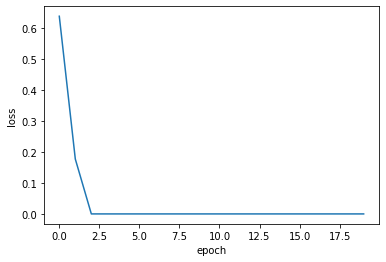

In [134]:

plt.plot(h.history['loss'])
plt.xlabel("epoch")
plt.ylabel("loss")

In [135]:
y_pred = m.predict(X_test)

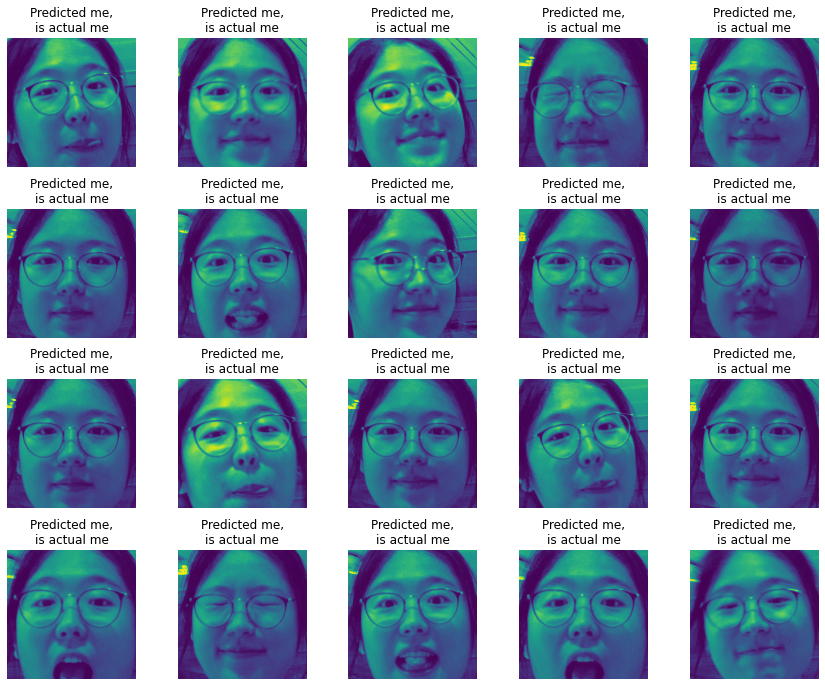

In [136]:
subplots= np.ceil(np.sqrt(y_pred.shape[0]))

plt.figure(figsize=(12,12))

for i in range(y_pred.shape[0]):
    p = "me" if y_pred[i] > 0.5 else "them"
    a = "me" if y_test[i] > 0.5 else "them"
    
    plt.subplot(subplots, subplots, 1+i)
    plt.imshow(X_test[i][:,:,0])
    plt.axis('off')
    plt.title(f"Predicted {p},\nis actual {a}")
    
plt.tight_layout()

In [137]:
m.save("Yiran_face_bw.h5")